In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from pandas.core.groupby.groupby import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,r2_score

In [108]:
df=pd.DataFrame(pd.read_csv('./meal_time.csv'))
df.head()

,Day,Starting time,Ending time,Category
0,19/09/2023,7:32,7:52,BreakFast
1,19/09/2023,12:36,13:01,Lunch
2,19/09/2023,17:04,17:14,Tea
3,19/09/2023,19:40,20:13,Dinner
4,20/09/2023,8:53,9:20,BreakFast


In [109]:
df['Starting time'] = pd.to_datetime(df['Starting time']).dt.time
df['Ending time'] = pd.to_datetime(df['Ending time']).dt.time
df.head()

,Day,Starting time,Ending time,Category
0,19/09/2023,07:32:00,07:52:00,BreakFast
1,19/09/2023,12:36:00,13:01:00,Lunch
2,19/09/2023,17:04:00,17:14:00,Tea
3,19/09/2023,19:40:00,20:13:00,Dinner
4,20/09/2023,08:53:00,09:20:00,BreakFast


**Define time windows for each category**

In [110]:
time_windows = {
    'BreakFast': ('7:30', '10:20'),
    'Lunch': ('12:30', '14:20'),
    'Tea': ('17:00', '17:50'),
    'Dinner': ('19:30', '20:50')
}

**Function to scale starting time within the specified window**

In [111]:
def scale_starting_time(row):
    category = row['Category']
    start_window, end_window = time_windows.get(category, (None, None))

    if start_window and end_window:
        start_window = pd.to_datetime(start_window).time()
        end_window = pd.to_datetime(end_window).time()

        # Convert time values to seconds for subtraction
        scaled_start_time = (row['Starting time'].hour * 3600 +
                             row['Starting time'].minute * 60 +
                             row['Starting time'].second) - \
                            (start_window.hour * 3600 +
                             start_window.minute * 60 +
                             start_window.second)+1

        # Normalize starting time within the window
        scaled_start_time /= (end_window.hour * 3600 +
                              end_window.minute * 60 +
                              end_window.second) - \
                             (start_window.hour * 3600 +
                              start_window.minute * 60 +
                              start_window.second)

        return scaled_start_time

    return None

**Apply the scaling function to create a new column 'Scaled Starting Time'**

In [112]:
df['Scaled Starting Time'] = df.apply(scale_starting_time, axis=1)
df.head()

,Day,Starting time,Ending time,Category,Scaled Starting Time
0,19/09/2023,07:32:00,07:52:00,BreakFast,0.011863
1,19/09/2023,12:36:00,13:01:00,Lunch,0.054697
2,19/09/2023,17:04:00,17:14:00,Tea,0.080333
3,19/09/2023,19:40:00,20:13:00,Dinner,0.125208
4,20/09/2023,08:53:00,09:20:00,BreakFast,0.488333


**Calculate time taken for each meal**

In [113]:
def calculate_time(row):
   time = (row['Ending time'].hour * 3600 + row['Ending time'].minute * 60 + row['Ending time'].second) - (row['Starting time'].hour * 3600 + row['Starting time'].minute * 60 + row['Starting time'].second)
   return time/60

df['Time Taken'] = df.apply(calculate_time,axis=1)
df.head()

,Day,Starting time,Ending time,Category,Scaled Starting Time,Time Taken
0,19/09/2023,07:32:00,07:52:00,BreakFast,0.011863,20.0
1,19/09/2023,12:36:00,13:01:00,Lunch,0.054697,25.0
2,19/09/2023,17:04:00,17:14:00,Tea,0.080333,10.0
3,19/09/2023,19:40:00,20:13:00,Dinner,0.125208,33.0
4,20/09/2023,08:53:00,09:20:00,BreakFast,0.488333,27.0


**A plot of the time taken against different days for each of meal type.**

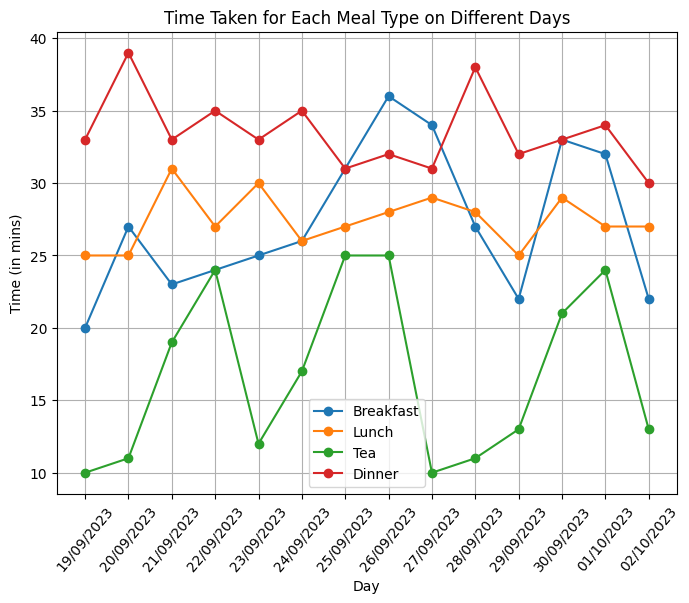

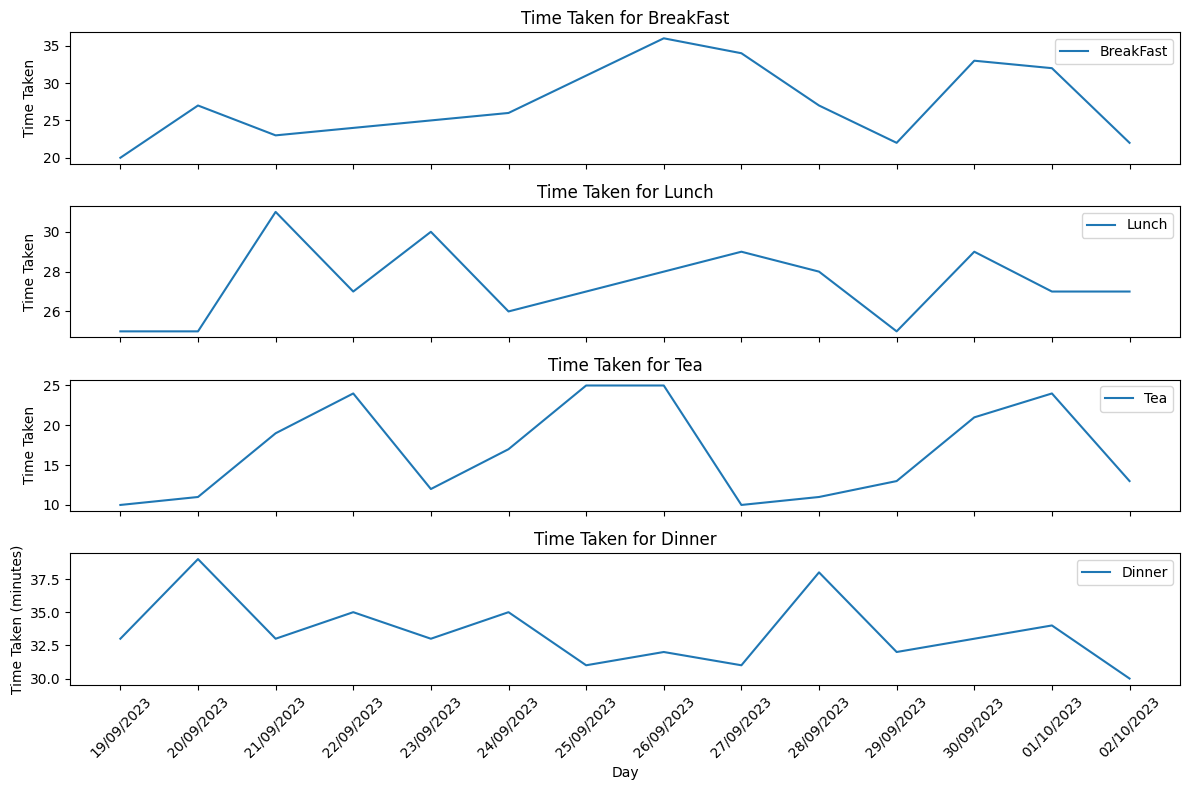

In [114]:
# Plotting


# Filter data for each meal type
breakfast_data = df[df['Category'] == 'BreakFast']
lunch_data = df[df['Category'] == 'Lunch']
tea_data = df[df['Category'] == 'Tea']
dinner_data = df[df['Category'] == 'Dinner']

plt.figure(figsize=(8, 6))

plt.plot(breakfast_data['Day'], breakfast_data['Time Taken'], label='Breakfast', marker='o')
plt.plot(lunch_data['Day'], lunch_data['Time Taken'], label='Lunch', marker='o')
plt.plot(tea_data['Day'], tea_data['Time Taken'], label='Tea', marker='o')
plt.plot(dinner_data['Day'], dinner_data['Time Taken'], label='Dinner', marker='o')

plt.title('Time Taken for Each Meal Type on Different Days')
plt.xlabel('Day')

plt.xticks(rotation=50)
plt.ylabel('Time (in mins)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting by category
meal_types = df['Category'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(meal_types), figsize=(12, 8), sharex=True)

# Iterate through each meal type
for i, meal_type in enumerate(meal_types):
    meal_data = df[df['Category'] == meal_type]
    sns.lineplot(x='Day', y='Time Taken', data=meal_data, label=meal_type, ax=axes[i])
    axes[i].set_title(f'Time Taken for {meal_type}')

# Beautify the plot
plt.xlabel('Day')
plt.ylabel('Time Taken (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




**A scatter plot of the time taken against Scaled Starting Time for each of meal type.**

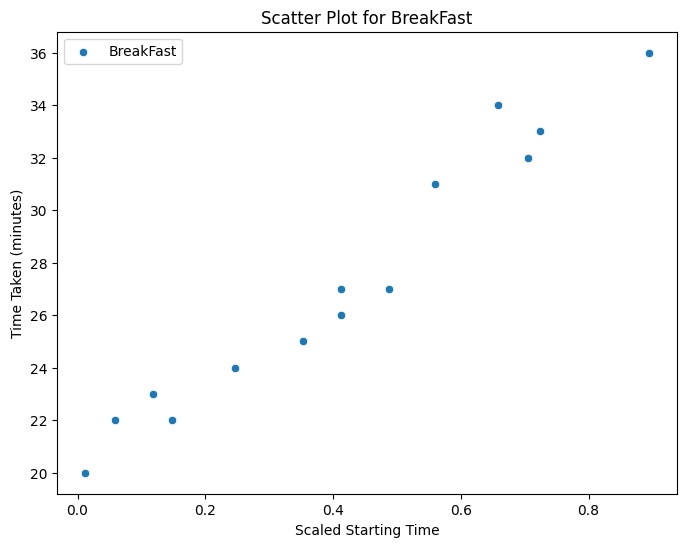

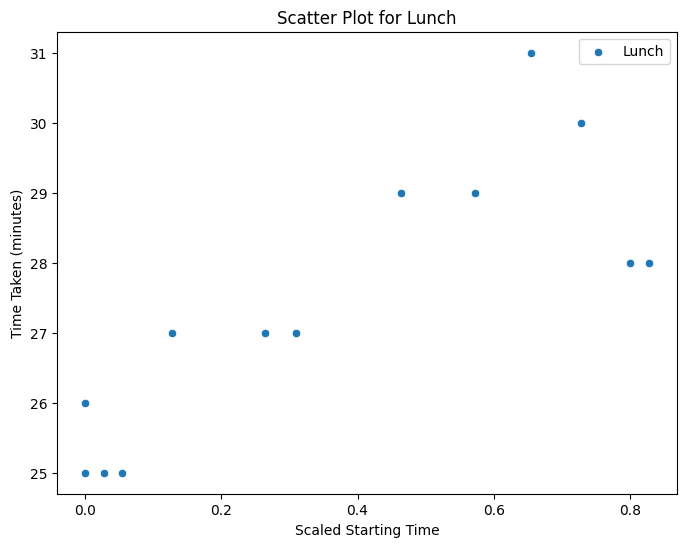

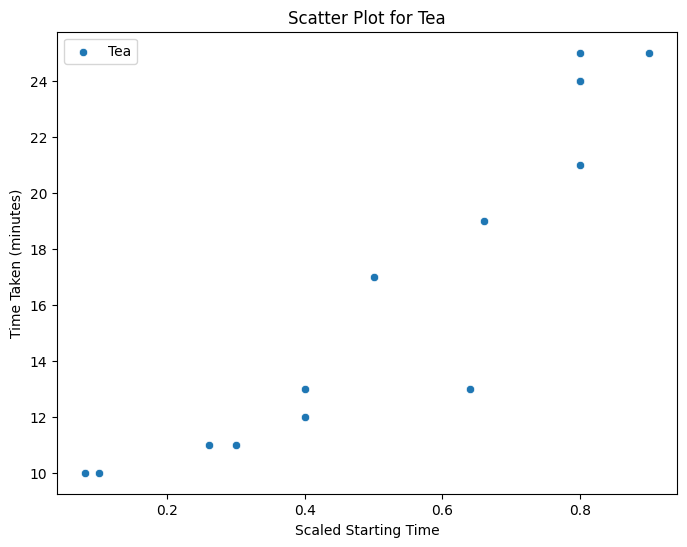

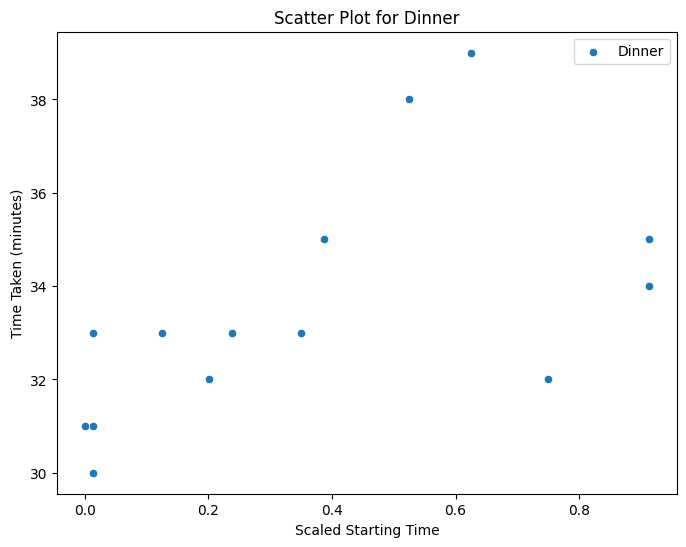

In [115]:
for meal_type in time_windows.keys():
    plt.figure(figsize=(8, 6))

    # Select data for the specific meal category
    meal_data = df[df['Category'] == meal_type]

    # Extract features and target
    x = meal_data['Scaled Starting Time']
    y = meal_data['Time Taken']


# Scatter plot
    sns.scatterplot(x='Scaled Starting Time', y='Time Taken', data=meal_data, label=meal_type)

    # Beautify the plot
    plt.title(f'Scatter Plot for {meal_type}')
    plt.xlabel('Scaled Starting Time')
    plt.ylabel('Time Taken (minutes)')
    plt.legend()

    plt.show()

#We are going to fit individual curve to data with respect to meal type.

**Define the polynomial regression model**



>   Polynomial regression model.
    :

> Parameters


   
> > 1.   params: Coefficients of the polynomial.
> > 2.   x: Independent variable.

> Returns:
> >Predicted values.








   


In [116]:
def polynomial_regression(params, x):
    return np.polyval(params[::-1], x)

**Negative log-likelihood function for polynomial regression**

> Negative log-likelihood function for polynomial regression.
> > Parameters:


> > > 1. params: Coefficients of the polynomial.
> > > 2. x: Independent variable.
> > > 3. y: Dependent variable.

> > Returns:
> > > Negative log-likelihood value

In [117]:
def negative_log_likelihood(params, x, y):
    y_pred = polynomial_regression(params, x)
    log_likelihood = -0.5 * np.sum((y - y_pred)**2)
    return -log_likelihood

**Function to fit polynomial regression using Maximum Likelihood Estimation**
> Fit polynomial regression model using Maximum Likelihood Estimation.

> > Parameters:
> > > 1. x: Independent variable.
> > > 2. y: Dependent variable.
> > > 3. degree: Degree of the polynomial.

> > Returns:
> > > Coefficients of the polynomial.


In [118]:
def fit_polynomial_regression(x, y, degree):

    # Initial guess for parameters
    initial_params = np.zeros(degree + 1)

    # Minimize negative log-likelihood to find parameters
    result = minimize(negative_log_likelihood, initial_params, args=(x, y), method='BFGS')
    return result.x

**Iterate through each meal category**

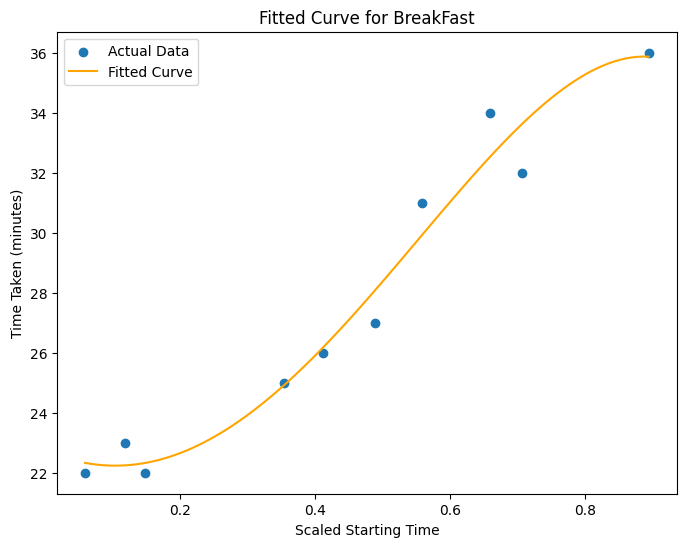

Parameters for BreakFast: [ 22.73021859  -9.51925122  45.14679208   9.66078474 -33.40322228]


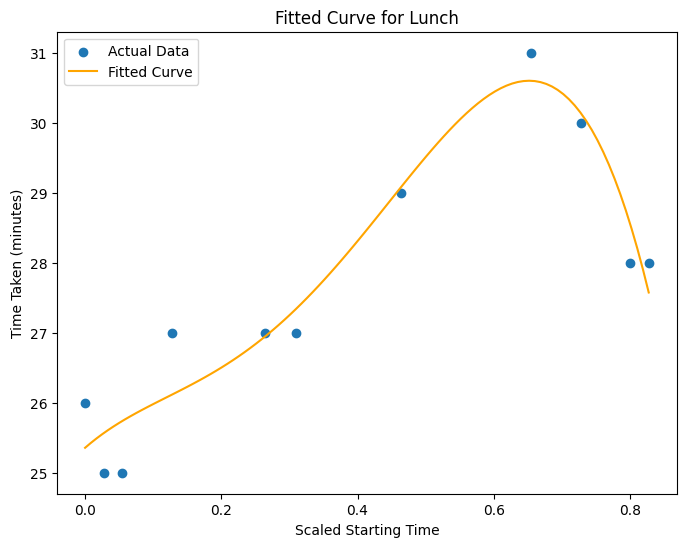

Parameters for Lunch: [  25.35495826    8.49181356  -33.16086235  117.50777932 -103.83513102]


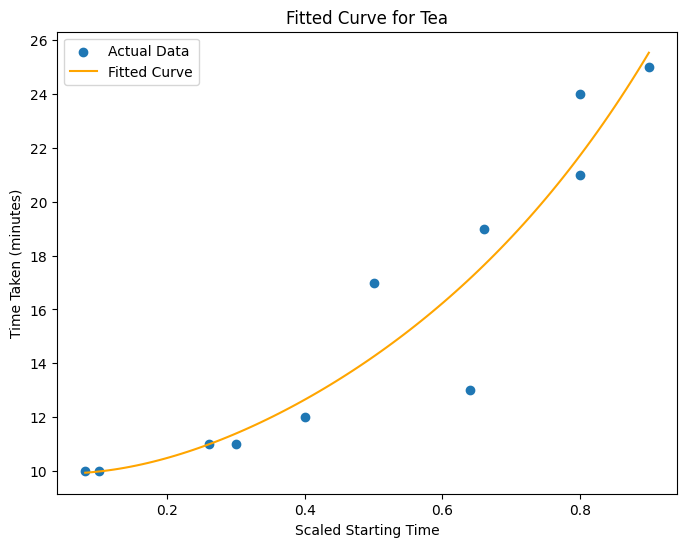

Parameters for Tea: [  9.97517363  -2.88673792  32.0865898  -27.96569481  19.11077187]


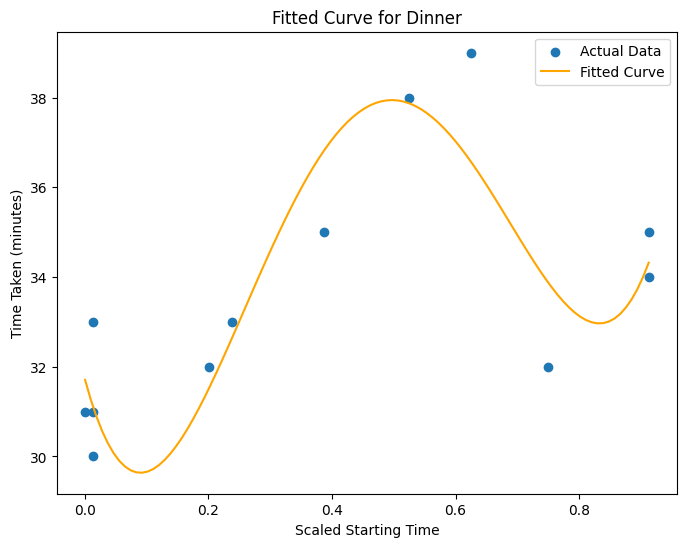

Parameters for Dinner: [  31.71761066  -51.01477409  365.5547051  -648.53279962  342.58243112]


In [119]:
# Split data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Dictionary to store parameters for each category
category_params = {}

for meal_type in time_windows.keys():
    plt.figure(figsize=(8, 6))

    # Select data for the specific meal category
    meal_data = train_df[train_df['Category'] == meal_type]

    # Extract features and target
    x = meal_data['Scaled Starting Time']
    y = meal_data['Time Taken']

    # Fit polynomial regression model
    degree = 4  # We can adjust the degree of the polynomial
    params = fit_polynomial_regression(x, y, degree)


    # Store parameters for the category
    category_params[meal_type] = params

    # Plotting scatter plot
    plt.scatter(x, y, label='Actual Data')

    # Plotting the fitted curve
    x_range = np.linspace(min(x), max(x), 100)
    y_pred = polynomial_regression(params, x_range)
    plt.plot(x_range, y_pred, label='Fitted Curve', color='orange')

    plt.title(f'Fitted Curve for {meal_type}')
    plt.xlabel('Scaled Starting Time')
    plt.ylabel('Time Taken (minutes)')
    plt.legend()

    plt.show()

    print(f"Parameters for {meal_type}: {params}")

**Test Results**

In [120]:
x_test = test_df['Scaled Starting Time']
def check_condition(row):
  parms=category_params[row['Category']]
  parms=parms[::-1]
  x_test=row['Scaled Starting Time']
  return np.polyval(parms,x_test)

# Apply the function row-wise to create a new column 'is_target_value'
y_pred_combined= test_df.apply(lambda row: check_condition(row), axis=1)


test_df['Predicted Time']=y_pred_combined
display(test_df)

y_test = test_df['Time Taken']
# Evaluate performance using R-squared score
combined_r2_score = r2_score(y_test, y_pred_combined)
print(f"R-squared Score on Testing Data: {combined_r2_score}")

,Day,Starting time,Ending time,Category,Scaled Starting Time,Time Taken,Predicted Time
0,19/09/2023,07:32:00,07:52:00,BreakFast,0.011863,20.0,22.623663
5,20/09/2023,12:30:00,12:55:00,Lunch,0.000152,25.0,25.356244
33,27/09/2023,13:33:00,14:02:00,Lunch,0.572879,29.0,30.245727
13,22/09/2023,13:04:00,13:31:00,Lunch,0.309242,27.0,27.335257
19,23/09/2023,19:58:00,20:31:00,Dinner,0.350208,33.0,35.983191
50,01/10/2023,17:40:00,18:04:00,Tea,0.800333,24.0,21.721840
36,28/09/2023,08:40:00,09:07:00,BreakFast,0.411863,27.0,26.181667
26,25/09/2023,17:40:00,18:05:00,Tea,0.800333,25.0,21.721840
44,30/09/2023,09:33:00,10:06:00,BreakFast,0.723627,33.0,33.983979
12,22/09/2023,08:12:00,08:36:00,BreakFast,0.247157,24.0,23.156542


R-squared Score on Testing Data: 0.8772922878742045


**A linear regression model**

R-squared Score: -0.020557342901488918


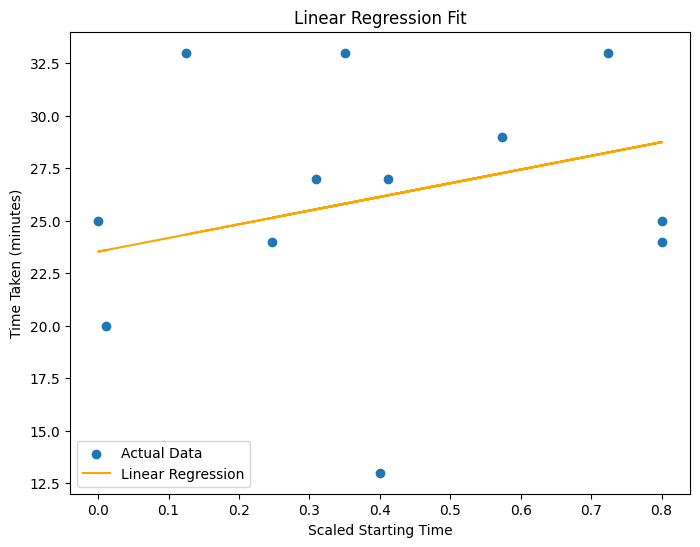

In [121]:
# Convert 'Scaled Starting Time' to a 2D array
X = df[['Scaled Starting Time']].values

# Reshape 'Time Taken' to a 1D array
y = df['Time Taken'].values

# Reshape 'Scaled Starting Time' to a 2D array
X = X.reshape(-1, 1)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linear_model.predict(X_test)

# Evaluate the model's performance using R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2}')

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label='Actual Data')
plt.plot(X_test, y_pred, label='Linear Regression', color='orange')
plt.title('Linear Regression Fit')
plt.xlabel('Scaled Starting Time')
plt.ylabel('Time Taken (minutes)')
plt.legend()
plt.show()


Here we can see first model have good
R-squared Score on Testing Data: 0.8772922878742045

Where linear regression have very bad
R-squared Score: -0.020557342901488918

so from this we can say that linear regression fit very poorly
